In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda,BatchNormalization, Dropout
from tensorflow.keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

In [3]:
import pandas as pd
import random

In [4]:
def processImage(input_path, target_size=(150, 220)):    
    # Cargar la imagen
    img = cv2.imread(input_path)
    
    # Calcular la relación de aspecto
    aspect_ratio = img.shape[1] / img.shape[0]
    aspect_ratio_target = target_size[1] / target_size[0]
    
    # Determinar el nuevo tamaño manteniendo la relación de aspecto
    if aspect_ratio_target > aspect_ratio:
        new_height = img.shape[0]
        new_width = int(aspect_ratio_target * img.shape[0])
    else:
        new_height = int(img.shape[1] / aspect_ratio_target)
        new_width = img.shape[1]
    
    # Crear una nueva imagen con fondo blanco
    new_img = np.ones((new_height, new_width, 3), dtype=np.uint8) * 255
    
    # Calcular las coordenadas para centrar la imagen redimensionada
    top_left_x = (new_width - img.shape[1]) // 2
    top_left_y = (new_height - img.shape[0]) // 2
    
    # Pegar la imagen redimensionada en la nueva imagen con fondo blanco
    new_img[top_left_y:top_left_y + img.shape[0], top_left_x:top_left_x + img.shape[1]] = img
    
    # Redimensionar la imagen al tamaño objetivo
    new_img = cv2.resize(new_img, (target_size[1],target_size[0]))
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    # Aplicar el algoritmo de Otsu para obtener el umbral óptimo
    _, umbral = cv2.threshold(imagen_gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invertir la imagen
    imagen_invertida = 255 - umbral
    return imagen_invertida

def extraerDataset(folder,input_shape):
    textodataset="firmaOriginal,firmaComparacion,EsValida\n"
    dataset=[]
    for subfolder in os.listdir(folder):    
        if "forg" not in subfolder:
            print(subfolder)
            rutaSubfolderA=folder+"\\"+subfolder #obtenemos la ruta de la carpeta firmas originales
            rutaSubfolderB=folder+"\\"+subfolder+"_forg"#obtenemos la ruta de la carpeta de firmas falsas
            for imagen in os.listdir(rutaSubfolderA):
                imagenA=processImage(rutaSubfolderA+"\\"+imagen,input_shape)
                dataset.extend([([imagenA,processImage(rutaSubfolderA+"\\"+imagenReal,input_shape)],1) for imagenReal in os.listdir(rutaSubfolderA) if imagenReal!=imagen])            
                textodataset+="\n".join([imagen+","+imagenReal+","+str(1) for imagenReal in os.listdir(rutaSubfolderA) if imagenReal!=imagen])+"\n"

                #dataset.extend([([imagenA,processImage(rutaSubfolderB+"\\"+imagenFalsa,input_shape)],0.49) for imagenFalsa in os.listdir(rutaSubfolderB)][:6])            
                #textodataset+="\n".join([imagen+","+imagenFalsa+","+str(0) for imagenFalsa in os.listdir(rutaSubfolderB)])+"\n"

                dataset.extend([([imagenA,processImage(folder+"\\"+subfolderNegativas+"\\"+random.choice(os.listdir(folder+"\\"+subfolderNegativas)),input_shape)],0) for subfolderNegativas in os.listdir(folder) if subfolder not in subfolderNegativas])            
                #textodataset+="\n".join([imagen+","+imagenFalsa+","+str(0) for imagenFalsa in os.listdir(rutaSubfolderB)])+"\n"
                
    # Abrir un archivo CSV para escribir
    with open('dataset.csv', 'w', newline='') as csvfile:
        # Crear un objeto escritor CSV
        csvwriter = csv.writer(csvfile)

        lines = textodataset.split('\n')
        # Escribir cada línea en el archivo CSV
        for line in lines:
            # Separar cada línea en columnas
            row = line.split(',')
            csvwriter.writerow(row)
    return dataset

In [5]:
def build_siamese_model(input_shape):
    # Definición de la arquitectura de la subred
    input = Input(shape=input_shape)
    x = Conv2D(120, (11, 11),strides=(3, 3), padding='valid', activation='relu')(input)#11 712
    x = MaxPooling2D(strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(300, (5, 5),strides=(1, 1), padding='same', activation='relu')(x)#614 656
    x = MaxPooling2D(strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(400, (3, 3),strides=(1, 1), padding='same', activation='relu')(x)#885 120
    x = Conv2D(400, (3, 3),strides=(1, 1), padding='same', activation='relu')(x)#1 327 488
    x = Conv2D(280, (3, 3),strides=(1, 1), padding='same', activation='relu')(x)#1 327 488
    x = MaxPooling2D(strides=(2, 2))(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(2420, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(2420, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    model = Model(inputs=input, outputs=x)
    return model

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(sum_square)

def build_complete_siamese_network(input_shape):
    # Crear la subred
    base_network = build_siamese_model(input_shape)
    
    # Entradas para las dos imágenes
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    # Obtener la representación de las imágenes usando la misma red
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    # Calcular la distancia euclidiana
    distance = Lambda(euclidean_distance)([processed_a, processed_b])

    # Modelo final
    model = Model(inputs=[input_a, input_b], outputs=distance)
    return model
 
def contrastive_loss(y_true, y_pred):
    margin = 1
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

In [6]:
x=np.arange(0,1,0.01)
y=[contrastive_loss(1.0,i) for i in x]

In [7]:
y2=[contrastive_loss(0.0,i) for i in x]

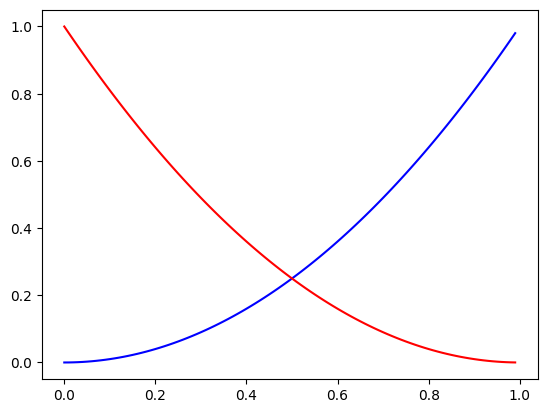

In [8]:
plt.plot(x,y,'blue')
plt.plot(x,y2,'red')

In [9]:
for i in range (10):
    if i%2==0:
        print(1,' ',-i/10,' ',contrastive_loss(1,-i/10))
    else:
        print(0,' ',-i/10,' ',contrastive_loss(0,-i/10))

1   0.0   tf.Tensor(0.0, shape=(), dtype=float32)
0   -0.1   tf.Tensor(1.21, shape=(), dtype=float32)
1   -0.2   tf.Tensor(0.040000003, shape=(), dtype=float32)
0   -0.3   tf.Tensor(1.6899998, shape=(), dtype=float32)
1   -0.4   tf.Tensor(0.16000001, shape=(), dtype=float32)
0   -0.5   tf.Tensor(2.25, shape=(), dtype=float32)
1   -0.6   tf.Tensor(0.36, shape=(), dtype=float32)
0   -0.7   tf.Tensor(2.89, shape=(), dtype=float32)
1   -0.8   tf.Tensor(0.64000005, shape=(), dtype=float32)
0   -0.9   tf.Tensor(3.61, shape=(), dtype=float32)


In [10]:
# Datos de entrenamiento
dataset=extraerDataset("data",(150, 220))
# Divide la lista en un 80% para entrenamiento y 20% para validación
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

pairs_train_a = np.array([item[0][0] for item in train_data],dtype=np.float32)
pairs_train_b = np.array([item[0][1] for item in train_data],dtype=np.float32)
labels_train = np.array([item[1] for item in train_data] , dtype=np.float32)

pairs_val_a = np.array([item[0][0] for item in val_data],dtype=np.float32)
pairs_val_b = np.array([item[0][1] for item in val_data],dtype=np.float32)
labels_val = np.array([item[1] for item in val_data] , dtype=np.float32)

049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069


In [11]:
print("tamaño dataset: ",len(dataset))
print("tamaño entrenamiento: ",len(train_data))
print("tamaño validación: ",len(val_data))

tamaño dataset:  12852
tamaño entrenamiento:  10281
tamaño validación:  2571


a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


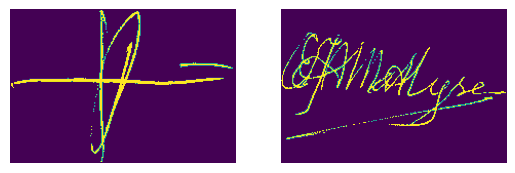

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


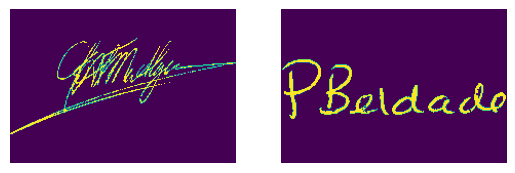

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


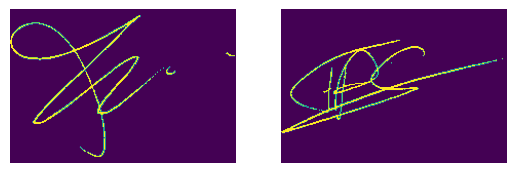

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


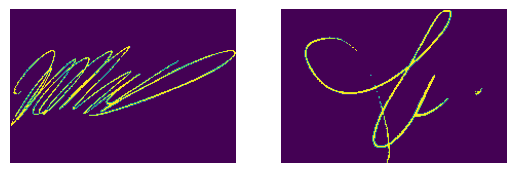

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


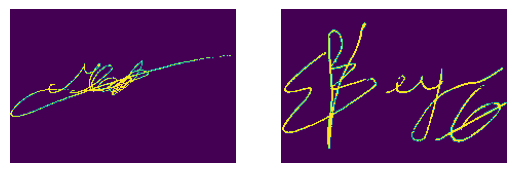

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


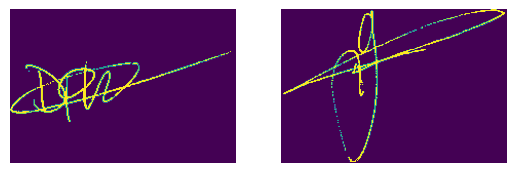

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


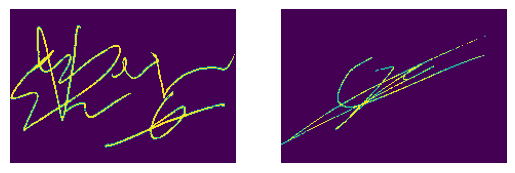

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


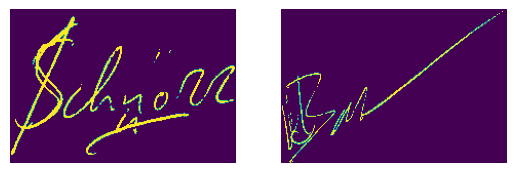

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


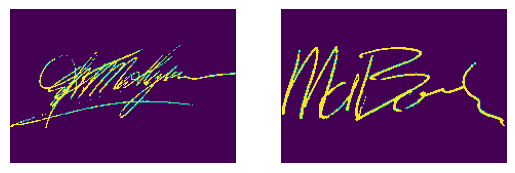

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


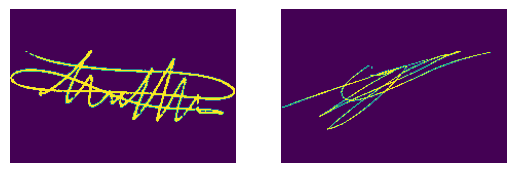

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


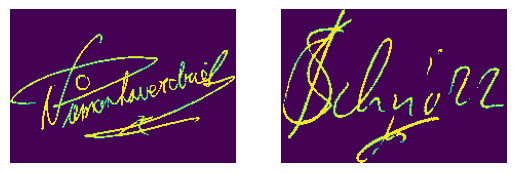

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


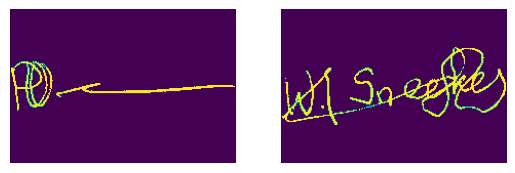

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


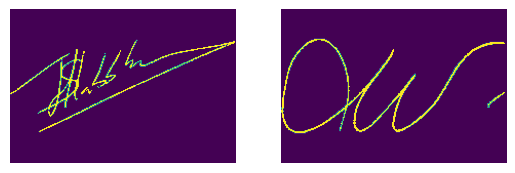

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 1.0


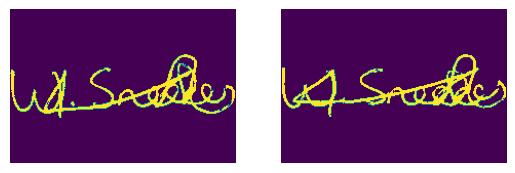

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 1.0


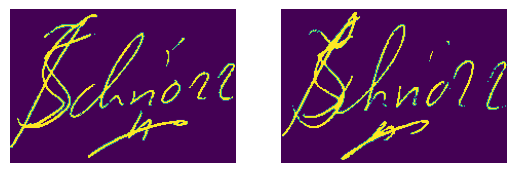

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


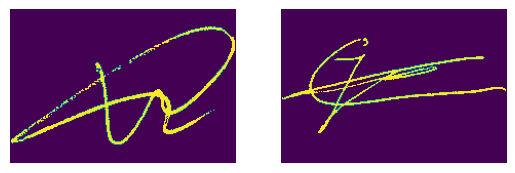

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


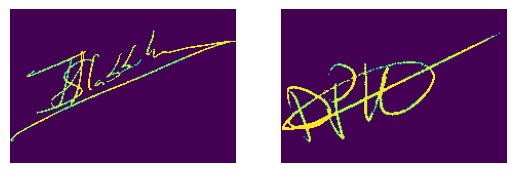

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


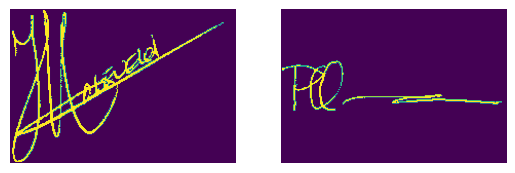

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


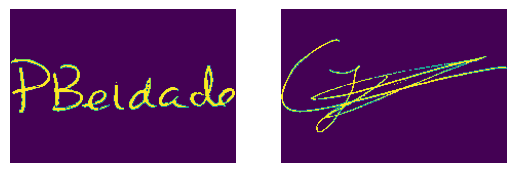

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


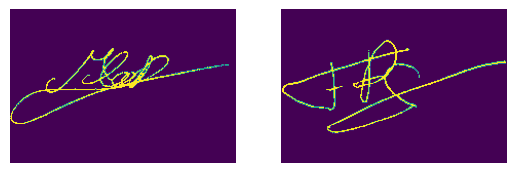

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 1.0


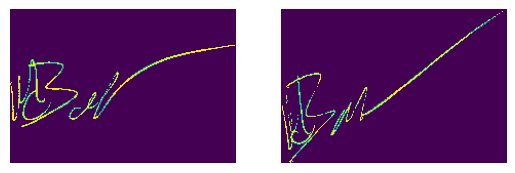

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 1.0


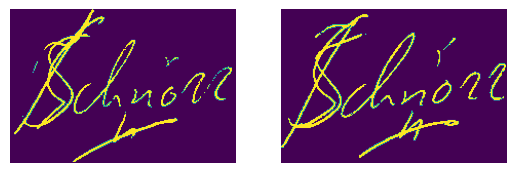

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0


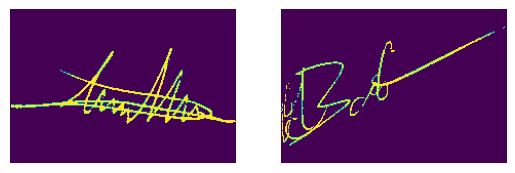

a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 1.0


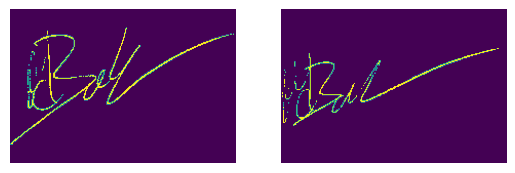

In [12]:
for i in range(0,24,1):
    a=pairs_train_a[i]
    b=pairs_train_b[i]
    y=labels_train[i]
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype} {y}')
    fig, axes = plt.subplots(1, 2)
    # Mostrar la primera imagen en el subplot 1
    axes[0].imshow(a)
    axes[0].axis('off')  # Opcional: Oculta los ejes
    # Mostrar la segunda imagen en el subplot 2
    axes[1].imshow(b)
    axes[1].axis('off')
    plt.show()

In [13]:
model = build_complete_siamese_network((150, 220, 1))  # Tamaño de imagen ejemplo
model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 150, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 2420)         37475100    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [15]:
# Entrenar el modelo
history=model.fit([pairs_train_a,pairs_train_b], labels_train, epochs=75, batch_size=64, validation_data=([pairs_val_a,pairs_val_b], labels_val))

Epoch 1/75
161/161 [==============================] - 27s 133ms/step - loss: 506.4153 - val_loss: 35.3253
Epoch 2/75
161/161 [==============================] - 19s 119ms/step - loss: 336.9804 - val_loss: 13.9573
Epoch 3/75
161/161 [==============================] - 20s 122ms/step - loss: 265.5869 - val_loss: 10.2767
Epoch 4/75
161/161 [==============================] - 20s 121ms/step - loss: 209.4154 - val_loss: 11.6375
Epoch 5/75
161/161 [==============================] - 19s 121ms/step - loss: 152.8422 - val_loss: 4.8701
Epoch 6/75
161/161 [==============================] - 19s 121ms/step - loss: 117.8852 - val_loss: 2.9342
Epoch 7/75
161/161 [==============================] - 19s 120ms/step - loss: 89.0575 - val_loss: 2.3125
Epoch 8/75
161/161 [==============================] - 20s 121ms/step - loss: 64.8393 - val_loss: 1.4635
Epoch 9/75
161/161 [==============================] - 20s 121ms/step - loss: 47.7171 - val_loss: 1.2384
Epoch 10/75
161/161 [==============================] -

In [18]:
salida=model.evaluate([pairs_train_a[:50],pairs_train_b[:50]], labels_train[:50])
salida

2/2 [==============================] - 0s 16ms/step - loss: 0.0836


0.08363499492406845

In [19]:
resultado=model.predict([pairs_train_a,pairs_train_b])
len(resultado)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
data={
    'verdadero':labels_train,
    'predicho':list(resultado)
}
df = pd.DataFrame(data)
df['final']=df['predicho'].apply(lambda x:1 if x<0.2 else 0)
df['comparacion']=df['verdadero']==df['final']
df['comparacion'].value_counts()

comparacion
True    12852
Name: count, dtype: int64

In [20]:
model.save('.\\model2')

INFO:tensorflow:Assets written to: .\model2\assets


INFO:tensorflow:Assets written to: .\model2\assets


In [ ]:
df[df['comparacion']==False]

,verdadero,predicho,final,comparacion
625,0.0,[0.4435141],1,False
647,0.0,[0.25662085],1,False
661,0.0,[0.48023504],1,False
676,0.0,[0.43246958],1,False
698,0.0,[0.26723164],1,False
...,...,...,...,...
12712,0.0,[0.48680323],1,False
12714,0.0,[0.46023247],1,False
12765,0.0,[0.48098084],1,False
12814,0.0,[0.49218088],1,False


1/1 [==============================] - 0s 13ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.5882913768291473


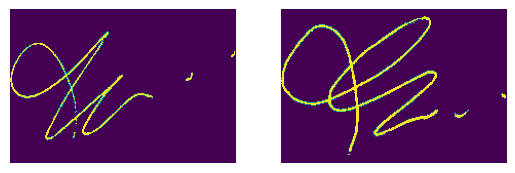

1/1 [==============================] - 0s 15ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.5433676838874817


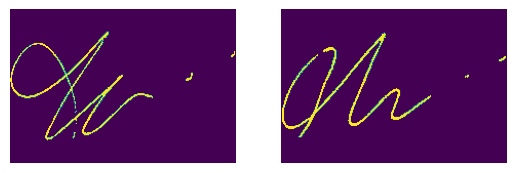

1/1 [==============================] - 0s 14ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.45587974786758423


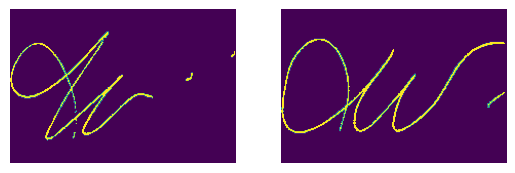

1/1 [==============================] - 0s 12ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.4815177321434021


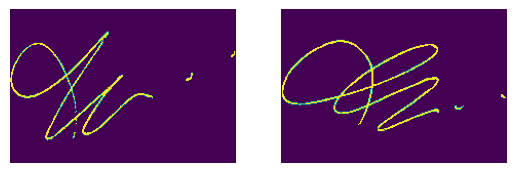

1/1 [==============================] - 0s 13ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.5966567695140839


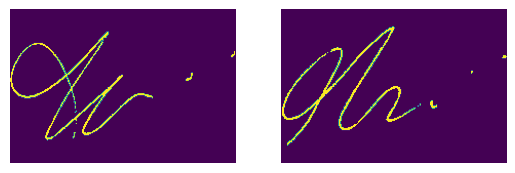

1/1 [==============================] - 0s 14ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.3217964768409729


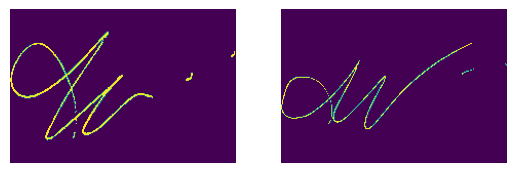

1/1 [==============================] - 0s 16ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.5717833340167999


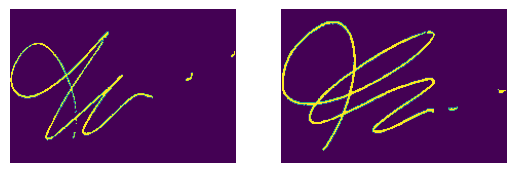

1/1 [==============================] - 0s 19ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.5227087140083313


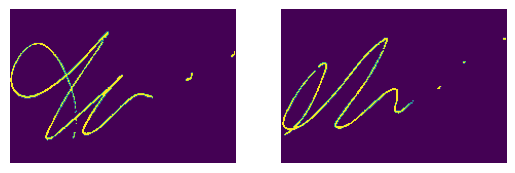

1/1 [==============================] - 0s 13ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.33660656213760376


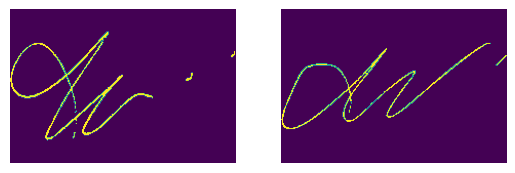

1/1 [==============================] - 0s 13ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.464089035987854


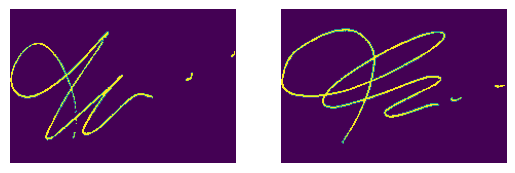

1/1 [==============================] - 0s 13ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.43830811977386475


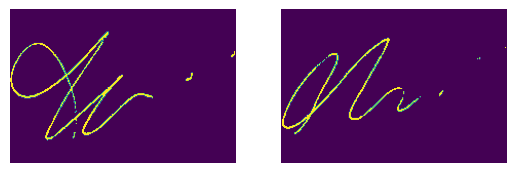

1/1 [==============================] - 0s 13ms/step
a shape=(150, 220), dtype=uint8
b shape=(150, 220), dtype=uint8
0.43408799171447754


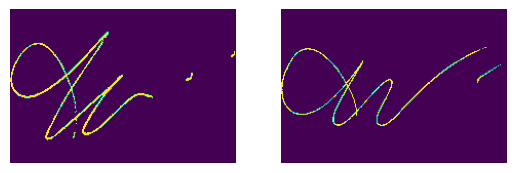

In [ ]:
for i in os.listdir('data/049_forg'):
    imagenA="data/049/01_049.png"
    imagenB="data/049_forg/"+i
    a=processImage(imagenA) 
    b=processImage(imagenB) 
    prediction=model.predict([np.array([a]),np.array([b])])[0][0]
    if prediction>1:
        prediction=0
    else:
        prediction=1-prediction
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'{prediction}')
    fig, axes = plt.subplots(1, 2)
    # Mostrar la primera imagen en el subplot 1
    axes[0].imshow(a)
    axes[0].axis('off')  # Opcional: Oculta los ejes
    # Mostrar la segunda imagen en el subplot 2
    axes[1].imshow(b)
    axes[1].axis('off')
    plt.show()

In [ ]:
a.shape

(150, 220)

1/1 [==============================] - 0s 16ms/step
a shape=(150, 220), dtype=float32
b shape=(150, 220), dtype=float32
y shape=(), dtype=float32 0.0-0.031212151050567627


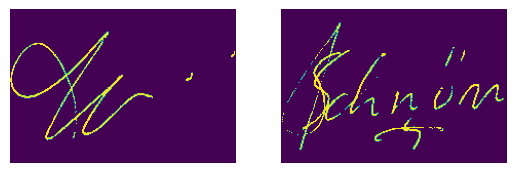

In [ ]:
for i in range(16,17,1):
    a=pairs_train_a[i]
    b=pairs_train_b[i]
    y=labels_train[i]
    prediction=model.predict([np.array([a]),np.array([b])])[0][0]
    if prediction>1:
        prediction=0
    else:
        prediction=1-prediction
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype} {y}-{prediction}')
    fig, axes = plt.subplots(1, 2)
    # Mostrar la primera imagen en el subplot 1
    axes[0].imshow(a)
    axes[0].axis('off')  # Opcional: Oculta los ejes
    # Mostrar la segunda imagen en el subplot 2
    axes[1].imshow(b)
    axes[1].axis('off')
    plt.show()